In [73]:
#Import pymc3 for bayesian testing
import pymc3 as pm
import seaborn as sns

Test number 1

In [16]:
#ab test results
n_a = 16500
n_b = 17000
obs_a = 30
obs_b = 50

In [29]:
#set up model for bayes ab testing
with pm.Model() as model: 
    # define priors
    prior_a = pm.Beta('prior_a', alpha=1, beta=100)
    prior_b = pm.Beta('prior_b', alpha=1, beta=100)

    # define likelihood
    like_v1 = pm.Binomial('like_v1', n=n_a, p=prior_a, observed=obs_a)
    like_v2 = pm.Binomial('like_v2', n=n_b, p=prior_b, observed=obs_b)
    
    # define metrics that are also to be looked at
    pm.Deterministic('difference', prior_b - prior_a)
    pm.Deterministic('relation', (prior_b/prior_a) - 1)

    # inference
    trace = pm.sample(draws=5000, step=pm.Metropolis(), start=pm.find_MAP(), progressbar=True)

C:\Users\290002494\AppData\Local\Continuum\Anaconda3\lib\site-packages\pymc3\tuning\starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -139.36, ||grad|| = 179.67: 100%|██████| 10/10 [00:00<00:00, 769.22it/s]
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [prior_b]
>Metropolis: [prior_a]
Sampling 2 chains: 100%|█████████████| 11000/11000 [00:17<00:00, 615.63draws/s]
The number of effective samples is smaller than 25% for some parameters.


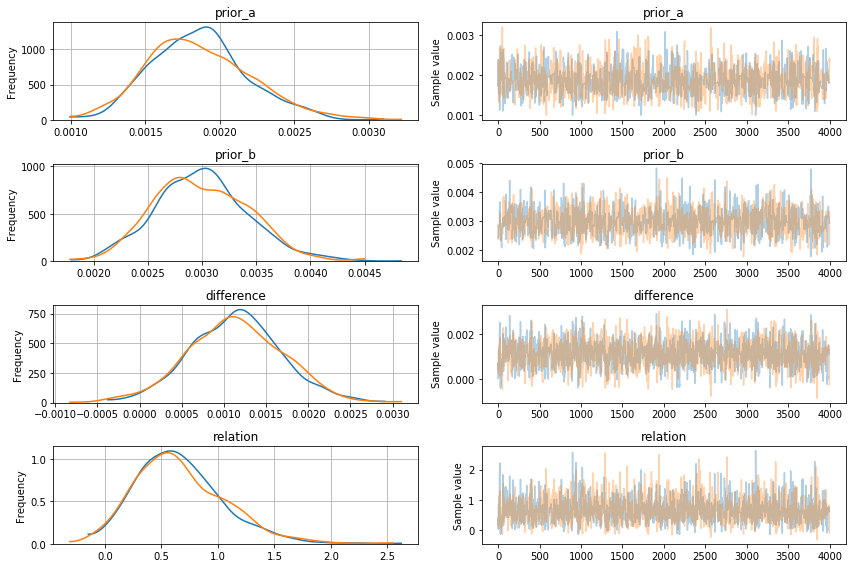

In [30]:
#this gives us our posterior distribution
_ = pm.traceplot(trace[1000:], grid=True)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000000010213A58>,
      dtype=object)

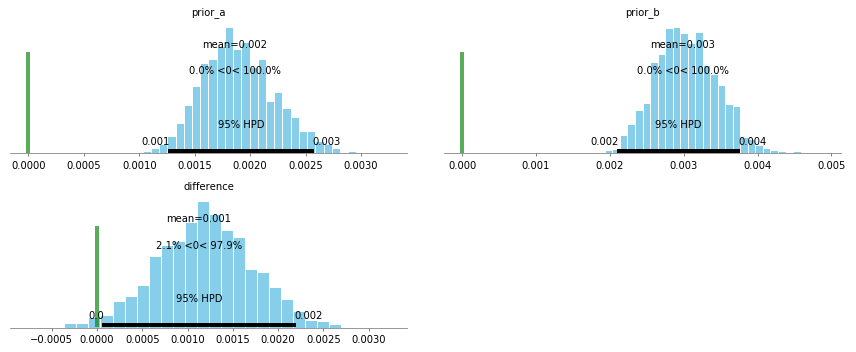

In [31]:
#this gives us an easy view to determine results of our experiement
pm.plot_posterior(trace, varnames=['prior_a', 'prior_b', "difference"],
                  ref_val = 0,
                  color='#87ceeb')

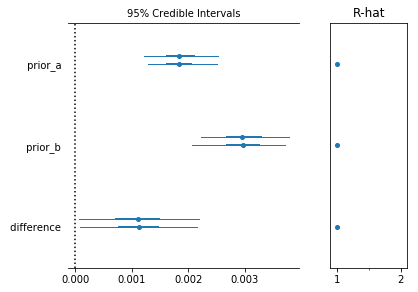

In [32]:
#alternate view if necessary
pm.forestplot(trace, varnames=['prior_a','prior_b', "difference"])

In [33]:
#Quick summary table
pm.summary(trace,varnames=['prior_a','prior_b', "difference"])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
prior_a,0.001861,0.000333,0.000008,0.001277,0.002557,1715.008915,1.000412
prior_b,0.002985,0.000425,0.000010,0.002125,0.003742,1631.480180,0.999900
difference,0.001123,0.000540,0.000012,0.000078,0.002177,1623.752104,1.000107


Recreate the baseball example from Example in R and get the same results!

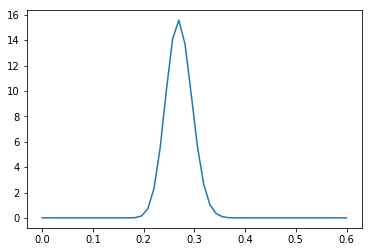

In [2]:
#First visualize the beta distribution
from scipy.stats import beta
import numpy as np
from matplotlib import pyplot as plt
x = np.linspace(0,.6,50)
rv = beta(81,219) #81 hits 219 misses
plt.plot(x, rv.pdf(x))

In [20]:
#Let's do an ab test now with two different batters career history
n_1 = 6911
n_2 = 12364
obs_1a = 2127
obs_2a = 3771

with pm.Model() as model: # context management
    # define priors... currently they are uninformative
    prior_a = pm.distributions.continuous.Beta('prior_a', alpha=1, beta=1)
    prior_b = pm.distributions.continuous.Beta('prior_b', alpha=1, beta=1)

    # define likelihood
    like_v1 = pm.Binomial('like_v1', n=n_1, p=prior_a, observed=obs_1a)
    like_v2 = pm.Binomial('like_v2', n=n_2, p=prior_b, observed=obs_2a)
    
    # define metrics that are also to be looked at
    pm.Deterministic('difference', prior_b - prior_a)

    # inference
    trace = pm.sample(draws=20000, step=pm.Metropolis(), progressbar=True)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [prior_b]
>Metropolis: [prior_a]
Sampling 2 chains: 100%|█████████████| 41000/41000 [00:56<00:00, 727.66draws/s]
The number of effective samples is smaller than 10% for some parameters.


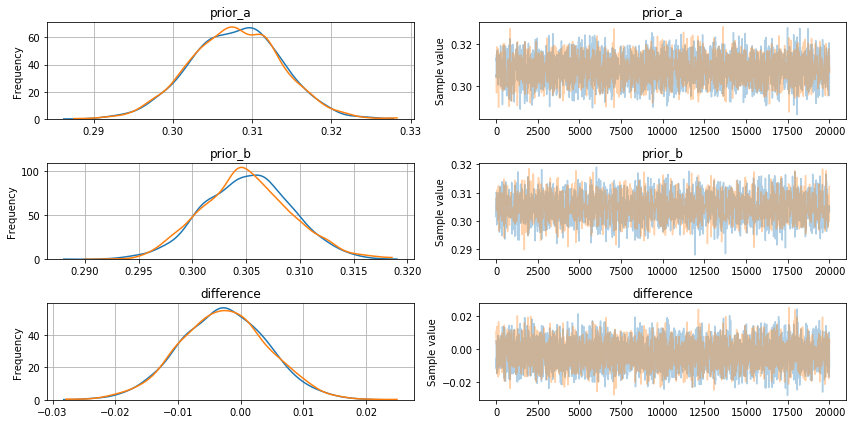

In [22]:
_ = pm.traceplot(trace[0:], grid=True)

In [50]:
import pandas as pd

#get specific bounds based on thresholds we are concerned with
def trace_quantiles(x):
    return pd.DataFrame(pm.quantiles(x, [2.5,50, 97.5]))
pm.summary(trace,varnames=['prior_a','prior_b', "difference"], stat_funcs = [trace_quantiles])

,2.5,50.0,97.5
prior_a,0.296889,0.307845,0.318848
prior_b,0.297206,0.304919,0.313140
difference,-0.016574,-0.002778,0.010958


In [53]:
#we can change our threshold of concern with the alpha parameter also
pm.summary(trace,varnames=['prior_a','prior_b', "difference"], alpha = .1)

,mean,sd,mc_error,hpd_5,hpd_95,n_eff,Rhat
prior_a,0.307820,0.005678,0.000102,0.298503,0.317106,3164.263628,1.000019
prior_b,0.305027,0.004091,0.000081,0.298516,0.312051,2545.448781,0.999985
difference,-0.002792,0.007006,0.000131,-0.014036,0.008952,2644.966469,0.999988


array([<matplotlib.axes._subplots.AxesSubplot object at 0x000000000CC39278>,
      dtype=object)

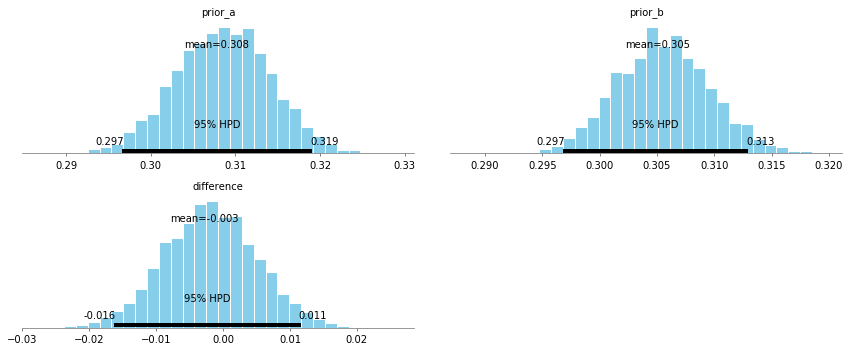

In [23]:
pm.plot_posterior(trace, varnames=['prior_a', "prior_b", "difference"],color='#87ceeb')

In [72]:
#get posterior distribution and determine how confident we are that player 1 is better than player 2
ppc = pm.sample_posterior_predictive(trace, samples=2000, model=model)
print("player 1 is better: ",np.mean(ppc["like_v1"]/n_1 > ppc["like_v2"]/n_2), "% of the time")

100%|████████████████████████████████████| 2000/2000 [00:01<00:00, 1681.81it/s]


player 1 is better:  0.615 % of the time


(0.2, 0.3)

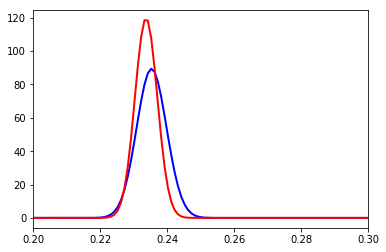

In [74]:
#analytical solution instead of mcmc
nvals = 1000
alpha_prior = 1
beta_prior = 1
n_1 = 6911
n_2 = 12364
obs_1a = 2127
obs_2a = 3771
x = np.linspace(0,1,nvals)
pA_analytic = [beta.pdf(x, alpha_prior + obs_1a, beta_prior + n_1) for x in np.linspace(0,1,nvals)]
pB_analytic = [beta.pdf(x, alpha_prior + obs_2a, beta_prior + n_2) for x in np.linspace(0,1,nvals)]
plt.plot(x, pA_analytic, 'b',lw=2, label='pA-analytic')
plt.plot(x, pB_analytic, 'r',lw=2, label='pB-analytic')
plt.xlim([0.2,0.3])

In [29]:
#alternative numerical solution using random pull from the beta distribution with our posterior parameters
np.mean(np.random.beta(2127,6911,1000) > np.random.beta(3771, 12364,1000))

0.606